Notes: 这一章 与学习目的关系不大，将采用阅读的方式完成.

https://www.learnpytorch.io/04_pytorch_custom_datasets/

“What is a custom dataset?" 

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*

But sometimes these existing functions may not be enough.

In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.  A custom dataset is specific dataset of own our own problem. 

## What we're going to cover

We're going to be applying the PyTorch Workflow we covered in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/) and [notebook 02](https://www.learnpytorch.io/02_pytorch_classification/) to a computer vision problem.

But instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

*What we're going to build. We'll use `torchvision.datasets` as well as our own custom `Dataset` class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.*

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. | 
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

## 0. Importing PyTorch and setting up device-agnostic code

In [37]:
import torch
from torch import nn

torch.__version__

'2.10.0+cu128'

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## 1. Getting Data

The data we are going to use is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).
Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Instead of 101 food classes though, we're going to start with 3: pizza, steak and sushi.

And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

If you'd like to see where the data came from you see the following resources:
* Original [Food101 dataset and paper website](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - the version of the data I downloaded for this notebook.
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - a notebook I used to format the Food101 dataset to use for this notebook.
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.

Let's write some code to download the formatted data from GitHub.

In [39]:
import requests
import zipfile
from pathlib import Path

# Setting up the data path
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download and unzip the data
if image_path.is_dir():
    print(f"{image_path} directory already exists, skipping download.")
else:
    print(f"{image_path} directory does not exist, downloading data...")
    image_path.mkdir(parents=True, exist_ok=True)
    #Download pizza,steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
    # Unzip the data    
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists, skipping download.


## 2. Become one with the data


Data preparation is paramount. Before building a model, become one with the data. Ask: What am I trying to do here? 

Before starting a project or building any kind of model, it's important to know what data you're working with.

In our case, we have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in separate directories titled with a particular class name.

For example, all images of pizza are contained in the pizza/ directory.

This format is popular across many different image classification benchmarks, including ImageNet (of the most popular computer vision benchmark datasets).

You can see an example of the storage format below, the images numbers are arbitrary.


The goal will be to **take this data storage structure and turn it into a dataset usable with PyTorch**.

> **Note:** The structure of the data you work with will vary depending on the problem you're working on. But the premise still remains: become one with the data, then find a way to best turn it into a dataset compatible with PyTorch.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk). 

```
pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

In [40]:
import os

def walk_through_dir(dir_path):
    """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
        
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


It looks like we've got about 75 images per training class and 25 images per testing class.

That should be enough to get started.

Remember, these images are subsets of the original Food101 dataset.

You can see how they were created in the [data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).

In [41]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize the data

Okay, we've seen how our directory structure is formatted.

Now in the spirit of the data explorer, it's time to *visualize, visualize, visualize!*

Let's write some code to:
1. Get all of the image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`. 
2. Pick a random image path using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
3. Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. And since we're working with images, we'll open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

Random image path: data/pizza_steak_sushi/test/pizza/2871261.jpg
Image class: pizza
Image height: 384
Image width: 512


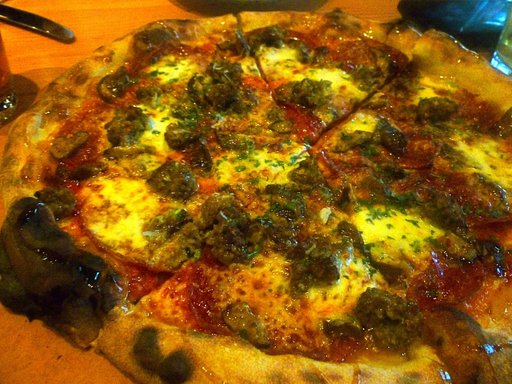

In [42]:
import random 
from PIL import Image

random.seed(42)

# Get all image paths
impage_paths_list = list(image_path.glob("*/*/*.jpg")) 

# 2. Get a ramdom image path(
random_image_path = random.choice(impage_paths_list)


# 3. Get image class from path name:
##the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
# 4. Open the image and print it
img = Image.open(random_image_path)

# 5. Print 
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

img

We can do the same thing with `matplotlib.pyplot.imshow()` expect we would have to convert the image to NumPy first

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

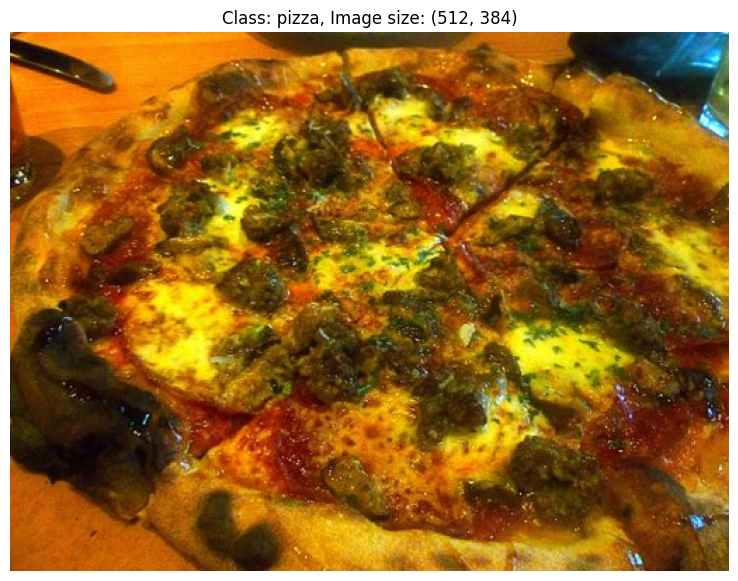

In [43]:
import numpy as np
import matplotlib.pyplot as plt


img_as_numpy = np.array(img)
plt.figure(figsize=(10, 7))
plt.imshow(img_as_numpy)
plt.title(f"Class: {image_class}, Image size: {img.size}")
plt.axis(False)


## 3. Transforming data

In order to load images in PyTorch, we need to do the following few things:

    1. Turn it into tensors(numerical representations of our images)
    2. Turn into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on. 

| **Problem space** | **Pre-built Datasets and Functions** |
| ----- | ----- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) for preparing our data.

Let's import some base libraries.

In [44]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms



### 3.1 Transforming data with torchvision.transforms


Currently what we have is the data sets are png which we converted to numpy in previou section. However, what we need now is to convert these numpy arrays into tensors such that PyTorch can work with. 

One of the ways we can do this is by using the `torchvisino.transforms` module.

`torchvisino.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation(practice of altering data and make it harder for model to learn). [数据增强]


Let's code out the following transform steps:

1. Resize the images using `transforms.Resize()` (from 512x512 to 64x64, the same shape as the images on CNN Explainer Website.)

2. Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (as a form of data augmentation)

3. Turn our images from PIL images to a PyTorch tensor using transforms.ToTensor().

We can compile all these steps using torchvision.transforms.Compose(). 



In [45]:
# Write transform for image

data_transform = transforms.Compose([
    #1. resize
    transforms.Resize((64, 64)),
    #2. Flip the images randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    # 3. Turn the image into a torch Tensor
    transforms.ToTensor() # This also converts all pixel values 
    #from range [0, 255] to [0, 1]
    ])

Let's write a function to transfer these images and plot them out.

In [46]:
# new functions alart:
random_image_path = random.sample(impage_paths_list, k = 1)
# This will return a list of one random image path,
# we can use [0] to get the string value of the path
random_image_path

[PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg')]

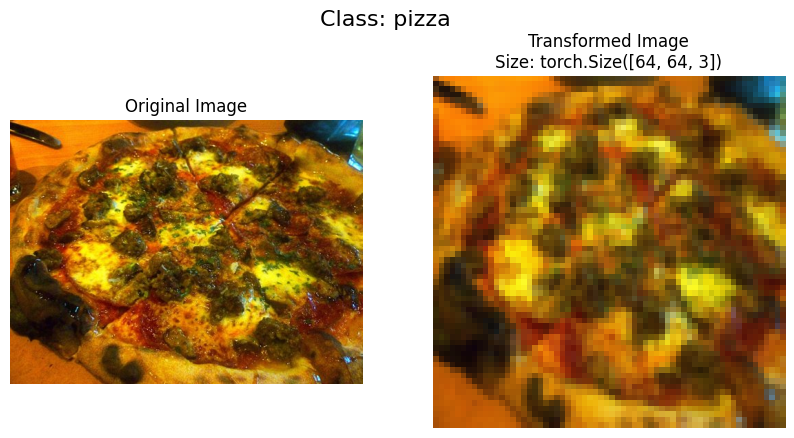

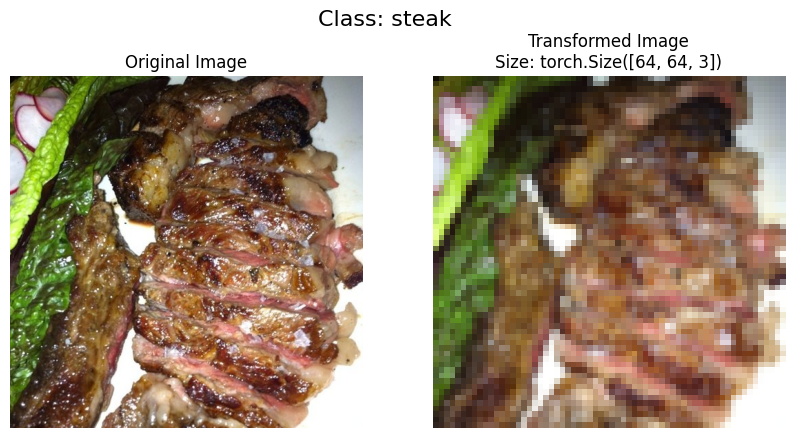

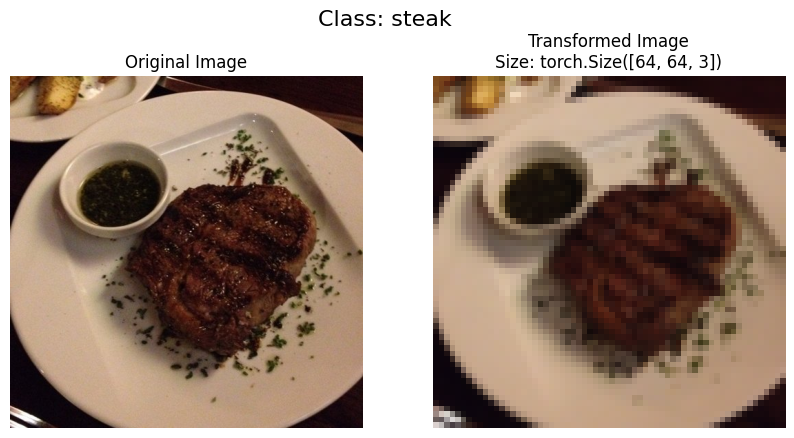

In [47]:
def plot_transformed_image(image_paths,transform, n=3,seed = 42):
    """
    Plots a transformed image given an image path and a transform.
    Args:
      image_path (str or pathlib.Path): target image path
        transform (torchvision.transforms.Compose): target transform to apply to the image 
    n (int): number of transformed images to create
    seed (int): random seed for reproducibility
    """
    # 0. Set random seed
    random.seed(seed)
    random_image_path = random.sample(image_paths,k=n)
    for image_path in random_image_path:
      with Image.open(image_path) as f:
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].imshow(f)
        ax[0].set_title("Original Image")
        ax[0].axis("off")
        # Transform and plot image
        #Note: permute() will change shape of the image to suit matplotlib
        #(PyTorch default is [C,H,W], MatPlotlib default is [H,W,C])
        Transformed_image = transform(f).permute(1,2,0)
        ax[1].imshow(Transformed_image)
        ax[1].set_title(f"Transformed Image\nSize: {Transformed_image.shape}")
        ax[1].axis("off")
        
        fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)
        
plot_transformed_image(impage_paths_list, data_transform)

Generally, the larger the shape of the image, the more information a model can recover.

For example, an image of size `[256, 256, 3]` will have 16x more pixels than an image of size `[64, 64, 3]` (`(256*256*3)/(64*64*3)=16`).

However, the tradeoff is that more pixels requires more computations.

> **Exercise:** Try commenting out one of the transforms in `data_transform` and running the plotting function `plot_transformed_images()` again, what happens?

## 4. Option 1 of loading data: Loading Image Data Using ImageFolder

Now we have all the data ready, the next step is to turn our image data into a `Dataset`capable of being used with PyTorch.

Since our data is in standard image classfication format, we can use the class [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders `train_dir` and `test_dir` passing in `transform=data_transform` to turn our images into tensors.

In [48]:
# use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(
    root=train_dir, #target folder of images
    transform=data_transform, #transforms to perform on data
    target_transform=None) # transforms to perform on labels(if necessary)

test_data = datasets.ImageFolder(
    root=test_dir, #target folder of images
    transform=data_transform, #transforms to perform on data
    target_transform=None) # transforms to perform on labels(if necessary)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Now we have the `Dataset` registered in PyTorch, Let's check them out by checking the `classes` and the `class_to_index` attributes as well as the lengths of our training and testing sets

In [49]:
#Get class names as a list

class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [50]:
# Getting class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [51]:
# Checking of length
len(train_data), len(test_data) 

(225, 75)

Checking our images and labels.. 

The ImageFolder class creates this structure automatically by reading the folder names as class names and images inside as samples, then applying data_transform to each image on the fly when you index into it.

In [52]:
img,label = train_data[0][0],train_data[0][1]

print(f"Image Tensor:\n{img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label datatype: {type(label)}")

Image Tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

We can see now our iamges are in the form of a tenser(with shape([3,64,64])) and the labels are in the form of an integer relating the a specific class(refering to the `class_to_idx` attribute)

let's plot a signle image tensor out using matplotlib.

We will first have to permute so that it's compatible. (from `CHW` to `HWC` for matplotlib)

Text(0.5, 1.0, 'Class: pizza')

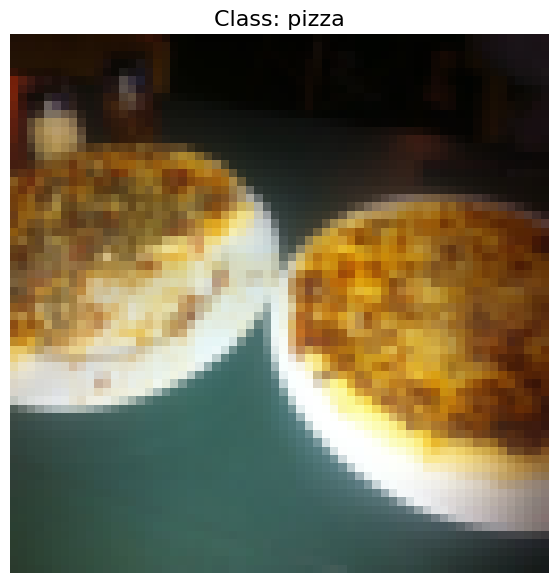

In [53]:

from tkinter import font


img_permuted = img.permute(1,2,0)
plt.figure(figsize=(10,7))
plt.imshow(img_permuted)
plt.axis(False)
plt.title(f"Class: {class_names[label]}", fontsize=16)

### 4.1 Turn loaded images into DataLoader's

If we remember perviously, the torch model will iterate throught what known as the `DataLoaders`. The DataLoader allows us to set up batch sizes, number of workers etc. 



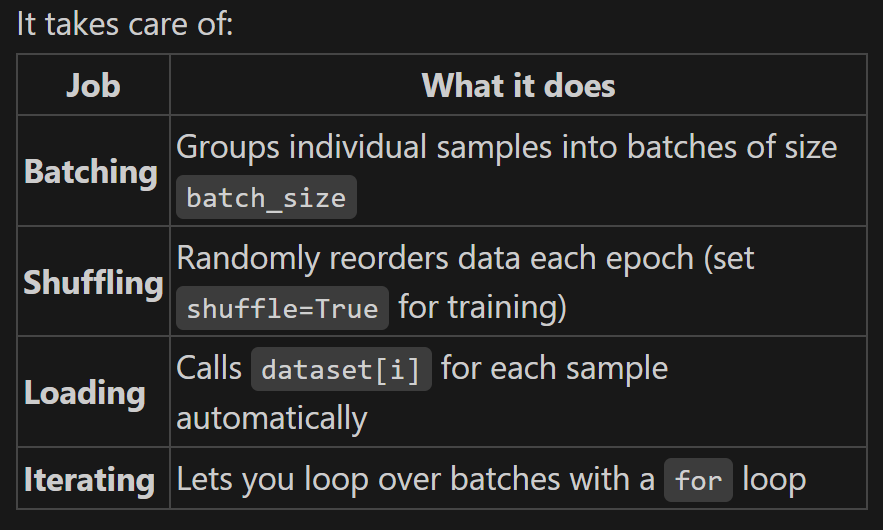

What's `num_worker`？
It defines how many subprocesses will be created to load your data. Think of it like the higher value of `num_workers` is set to, the more compute power PyTorch will use to load your data. It's offen time set to the total number of CPUs. [check uses `os.cpu_count()`]

This ensures the DataLoader recruits as many cores as possible to load data.

Note: There are more parameters you can get familiar with using torch.utils.data.DataLoader in the PyTorch documentation.

In [54]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, 
                              batch_size=1, 
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader   

(<torch.utils.data.dataloader.DataLoader at 0x7a60866c9100>,
 <torch.utils.data.dataloader.DataLoader at 0x7a608654fc20>)

In [55]:
#Checking the shape 
img,label = next(iter(train_dataloader))
print(f"Image shape:{img.shape} -> batch size, color channels, height, width")
print(f"Label shape: {label.shape} -> batch size")

Image shape:torch.Size([1, 3, 64, 64]) -> batch size, color channels, height, width
Label shape: torch.Size([1]) -> batch size


## 5. Option 2 of loading data: Loading Image Data with a Custom Dataset

## 5. Option 2: Loading Image Data with a Custom `Dataset`



What if a pre-built `Dataset` creator like [`torchvision.datasets.ImageFolder()`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) didn't exist?

Or one for your specific problem didn't exist?

Well, you could build your own.

But wait, what are the pros and cons of creating your own custom way to load `Dataset`'s?

| Pros of creating a custom `Dataset` | Cons of creating a custom `Dataset` |
| ----- | ----- |
| Can create a `Dataset` out of almost anything. | Even though you *could* create a `Dataset` out of almost anything, it doesn't mean it will work. | 
| Not limited to PyTorch pre-built `Dataset` functions. | Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues. |

To see this in action, let's work towards replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all `Dataset`'s in PyTorch). 

We'll start by importing the modules we need:
* Python's `os` for dealing with directories (our data is stored in directories).
* Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
* `torch` for all things PyTorch.
* PIL's `Image` class for loading images.
* `torch.utils.data.Dataset` to subclass and create our own custom `Dataset`.
* `torchvision.transforms` to turn our images into tensors.
* Various types from Python's `typing` module to add type hints to our code.

> **Note:** You can customize the following steps for your own dataset. The premise remains: write code to load your data in the format you'd like it.

In [56]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, List, Dict

remember how our instances of torchvision.datasets.ImageFolder() allowed us to sue the classes and class_to_idx attributes?

In [57]:

class_names = train_data.classes
class_names
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

### 5.1 Creating a helper function to get class names

Let's write a helper function capable of creating a list of class names(remember: this is just the folder name), and a dictornary of class names. 

To do so, we will:
1. Get the class name using `os.scandir()` to travers a target directory (ideally the directory is in stardard image classiffication format).

2. Raise an error if the class names aren't found(if this happens, there might be something wrong with the folder structure.)

3. Turn the class names into a dictory of numerical labels, one for each class. 


In [58]:
# find the directory for train_data, which we have set up perviously.
train_dir

target_directory = train_dir
print(f"Target directory for custom dataset: {target_directory}")

# Getting class names from the target directory
it = os.scandir(image_path / "train")
next(it)

it_list = list(os.scandir(image_path / "train"))
result = []
for entry in it_list:
    if entry.is_dir():
        result.append(entry.name)

class_names_found = sorted(result)

# or just one-line: class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found in target directory: {class_names_found}")

Target directory for custom dataset: data/pizza_steak_sushi/train
Class names found in target directory: ['pizza', 'steak', 'sushi']


Breaking it down from inside out:

image_path / "train" — Uses pathlib.Path's / operator to join the base path with "train", e.g. data/train.

os.scandir(...) — Returns an iterator of DirEntry objects for everything (files and folders) inside that directory.

list(...) — Converts the iterator into a list of DirEntry objects.

[entry.name for entry in ...] — List comprehension that extracts just the .name attribute from each DirEntry (the folder/file name as a string, not the full path).

sorted(...) — Sorts the names alphabetically, ensuring a consistent order.

Now we turn everything into full function

In [59]:
def find_classes(target_directory: str) -> List[str]:
    """
    Finds class names in target directory.
    Args:
      target_directory (str): target directory to find class names in.
    
    Returns:
      A list of class names found in target directory.
    """
    it_list = list(os.scandir(target_directory))
    classes = []
    for entry in it_list:
        if entry.is_dir():
            classes.append(entry.name)


    if not classes: # if classes is empty
      raise ValueError(f"No classes found in target directory: {target_directory}")

    # create a dictionary of index labels.
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

enumerate(classes)  produces:
1. `(0, "cat")`
2. `(1, "dog")`
3. `(2, "pizza")`

{cls_name: i for i, cls_name in enumerate(classes)}

这里正确的读法是 创建一个 dict， 格式是 {cls_name:i} 然后 for 每个clsses enumerate 所产生的键值对 i, cls_name， 赋值给 cls_name,i. 并调换顺序。 


for each (i,cls_name) pair 
(0, "cat")   →  "cat": 0
(1, "dog")   →  "dog": 1
(2, "pizza") →  "pizza": 2



In [60]:
# Lets test out

find_classes(target_directory)

(['steak', 'sushi', 'pizza'], {'steak': 0, 'sushi': 1, 'pizza': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder function

What we did in pervious section was to create a helper function that finds the class labels(and names) for each folder. 

Now the next step is to replicate the ImageFolder function. 

Remember what the ImageFolder function did. 


In [61]:
from torchvision import datasets
train_data = datasets.ImageFolder(
    root=train_dir, #target folder of images
    transform=data_transform, #transforms to perform on data
    target_transform=None) # transforms to perform on labels(if necessary)


the input(parameters) of the function 
-  `folder dictory`, 
- `transform function` that augemented the original data and 
- the `target_transform` function.  

The output is the dataset that 
- has the attributes of class name, class index, w
- ith the output being a turplep[torch.Tensor,int] ([img_in_Tensor,index])

Without doubt, we are going to sub-class the `Dataset`

Let's break it down:
1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and `transform` parameter (so we have the option to transform our data if needed).
3. Create several attributes for `paths` (the paths of our target images), `transform` (the transforms we might like to use, this can be `None`), `classes` and `class_to_idx` (from our `find_classes()` function).
4. Create a function to load images from file and return them, this could be using `PIL` or [`torchvision.io`](https://pytorch.org/vision/stable/io.html#image) (for input/output of vision data). 
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so you can call `len(Dataset)`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.


In [ ]:
from torch.utils.data import Dataset

#1. Subclass Dataset
class ImageFolderCustom(Dataset):
    
    #2. Init with target directory and transforms being the parameters
    def __init__(self, target_directory: str, transform: transforms.Compose):
        """
        Initializes the ImageFolderCustom dataset.
        Args:
          target_directory (str): target directory to find class names in.
          transform (torchvision.transforms.Compose): target transform to apply to the image 
        """
        # 3. Create class attributes
        # Get all image paths
        # Wrong! self.paths = list(pathlib.Path(target_directory).glob("*/*/*.jpg"))
        self.paths = list(pathlib.Path(target_directory).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's

        # Set up transform
        self.transform = transform
        # Create classes and class_to_idx attributes using find_classes() function
        self.classes, self.class_to_idx = find_classes(target_directory)
        

      # 4. Make function to load images
    def load_image(self, index:int) -> Image.Image:
      """
      Loads an image from the dataset.
      """
      image_path = self.paths[index]
      image = Image.open(image_path)
      return image
    
      # 5. Overwrite the __len__() method to return the length of the dataset
      #(optional but recommended to make it work with DataLoader)
    def __len__(self) -> int:
        """
        Returns the length of the dataset.
        """
        return len(self.paths)

        
      # 6. Overwrite the __getitem__() method to return a transformed image and its label
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Returns a transformed image and its label.
        Args:
          index (int: index of the image to return.
        """
        img = self.load_image(index)
        class_name = self.paths[index].parent.stem
        class_idx  = self.class_to_idx[class_name]
        if self.transform:
           
          return self.transform(img), class_idx
        else:
          return img, class_idx

In [63]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Now comes the moment of truth!

Let's turn our training images (contained in `train_dir`) and our testing images (contained in `test_dir`) into `Dataset`'s using our own `ImageFolderCustom` class.

In [64]:
train_data_custom = ImageFolderCustom(target_directory=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(target_directory=test_dir, transform=test_transforms)
print(f"Custom train data:\n{train_data_custom}\nCustom test data:\n{test_data_custom}")

Custom train data:
Custom test data:


In [65]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [66]:
train_data_custom.classes, train_data_custom.class_to_idx


(['steak', 'sushi', 'pizza'], {'steak': 0, 'sushi': 1, 'pizza': 2})

In [67]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [68]:
# Checking if the custom ImageFolder works the same as the ImageFolder from torchvision
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
False
False


### 5.3 Create a function to display random Image

Let's create a helper function called`display_random_images() to help us visualize

Specifically, it'll:
1. Take in a `Dataset` and a number of other parameters such as `classes` (the names of our target classes), the number of images to display (`n`) and a random seed. 
2. To prevent the display getting out of hand, we'll cap `n` at 10 images.
3. Set the random seed for reproducible plots (if `seed` is set). 
4. Get a list of random sample indexes (we can use Python's `random.sample()` for this) to plot.
5. Setup a `matplotlib` plot.
6. Loop through the random sample indexes found in step 4 and plot them with `matplotlib`.
7. Make sure the sample images are of shape `HWC` (height, width, color channels) so we can plot them.

Before moving forward, let's recap what we have done so far:

1. we downloaded data in the following direction
    ```bash 
    data/pizza_steak_sushi/
    - test
        - steak
        - sushi
        - pizza
    - train
        - steak
        - sushi
        - pizza
    ```
    define `image_path` as data/pizza_steak_sushi/
        `data_path` as data/
        `train_dir` as image_path/"train"
        `test_dir` as image_path / "test"
2. Transform data (Augmentation) using `transforms.Compose`
3. Turn images into Tensor(or datatype that contains tensor information) using ImageFolder
   1. Output of the ImageFolder is a data structure containing attribute path,classes,index, etc
4. Turn iamges into DataLoader
5. Created a customized ImageFolder 
   1. where we are.. try to plot out our Tensor data


In [69]:

def display_random_images(dataset:torch.utils.data.dataset.Dataset, 
                          classes: List[str] = None,
                          n:int = 10, 
                          display_shape:bool = True,
                          seed:int = None):
    """
    Displays random images from a dataset.
    Args:
      dataset (torch.utils.data.Dataset): target dataset to display images from.
      num_images (int): number of random images to display.
      seed (int): random seed for reproducibility.
    """
    random.seed(seed)
    if n > 10:
        n = 10
        display_shape = False
        print(f"n is set to {n}, but it's recommended to set n to 10, setting to 10 removes shape display to avoid clutter.")
    
    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    # random.sample() will return a list of n random indices from the dataset
    plt.figure(figsize=(16,8))
    for i,targ_sample in enumerate(random_samples_idx):
        # 可以用enumerate() 应为我们重写了__getitem__()方法，所以dataset[targ_sample]会返回一个元组(img, label)
        img, label = dataset[targ_sample][0], dataset[targ_sample][1]
        img = img.permute(1,2,0) # change shape from [C,H,W] to [H,W,C] for plotting
        plt.subplot(2,5,i+1)
        plt.imshow(img)
        title = f"Class: {classes[label]}" if classes else f"Label: {label}"
        if display_shape:
            title += f"\nShape: {img.shape}"
        plt.title(title, fontsize=10)
  
display_random_images(train_data_custom, classes=train_data_custom.classes, n=5, seed=42)
display_random_images(train_data, classes=train_data.classes, n=5, seed=42)


AttributeError: parent

<Figure size 1600x800 with 0 Axes>